## solution has been separated into three worksheets(notebook).
* classification for Status 12
* classification for Status 24
* Visualization and data distribution

In [1]:
# import pandas as pd
# from pyxlsb import open_workbook as open_xlsb

# data = []

# with open_xlsb('./Case-Study 1 Dataset.xlsb') as wb:
#     with wb.get_sheet('Static Data') as sheet:
#         for row in sheet.rows():
#             data.append([item.v for item in row])

# df = pd.DataFrame(data=data[1:],columns=data[0])

# df.shape

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# static data

In [1]:
stat_data=pd.read_excel('./Case-Study 1 Dataset.xlsx',sheet_name='Static Data',date_parser=True,na_values=['NA',' -   ',' NA '])

stat_data.head()

/root/anaconda3/envs/shopin/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/root/anaconda3/envs/shopin/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# performance data
<b>`agg_col`</b>:
    this is the aggregated column that has been made by taking mode across all the months for a given loanID

In [87]:
per_data=pd.read_csv('./agg_performance.csv',na_values=['#NA'])
per_data.head()

,LoanID,Status 12,Status 24,Agg_col
0,1,NaN,NaN,0.0
1,2,0.0,0.0,0.0
2,3,0.0,0.0,0.0
3,4,0.0,0.0,0.0
4,5,0.0,0.0,0.0


In [88]:
main_data=pd.concat(objs=[stat_data,per_data],axis=1)
main_data=main_data.loc[:,~main_data.columns.duplicated()]

main_data=main_data.rename(columns={"Borrower's Employment Status":'Borrower employement status'})

main_data.columns

Index(['Year', 'LoanID', 'Original Loan Size', 'Origination Date',
       'Original Term', 'APR', 'Loan Rate', 'LTV', 'Monthly Instalment',
       'Type 1', 'Type 2', 'Borrower employement status', 'Risk Tier',
       'Exposure At Default', 'Further Recovery Expected Y/N',
       'Recoveries @ 6m', 'Recoveries @ 9m', 'Recoveries @ 12m',
       'Total Recovery', 'Prepayment Amount', 'Status 12', 'Status 24',
       'Agg_col'],
      dtype='object')

In [89]:
main_data['Status 12'].value_counts()
main_data['Status 24'].value_counts()

0.0    11102
1.0     1024
Name: Status 24, dtype: int64

# outlier clipping: 
For all numerical column i am clipping otliers by 99 percentile. 

In [91]:
val_col=[ 'Original Loan Size', 'Original Term', 'APR',
       'Loan Rate', 'LTV', 'Monthly Instalment']

for col in val_col:
    val=main_data[col].quantile([0.99]).as_matrix()[0]
    main_data[col]=[val if i>val else i for i in main_data[col]]

/root/anaconda3/envs/shopin/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [132]:
train_data=main_data[main_data['Status 12'].notnull()]

In [133]:
def_1=train_data[train_data['Status 12']==1]
def_2=train_data[train_data['Status 12']==0].sample(1200)
train_data=pd.concat(objs=[def_1,def_2])
train_data['Status 12'].value_counts()

0.0    1200
1.0    1147
Name: Status 12, dtype: int64

In [134]:
train_data[['Type 1', 'Type 2', 'Borrower employement status', 'Risk Tier']].isnull().sum()

Type 1                         0
Type 2                         0
Borrower employement status    0
Risk Tier                      0
dtype: int64

### Label encoding:
Here i am creating dummy variables for categorical columns. 

In [135]:
train_data=train_data.join(pd.get_dummies(train_data[['Type 1','Type 2','Borrower employement status', 'Risk Tier']]))
train_data.columns

Index(['Year', 'LoanID', 'Original Loan Size', 'Origination Date',
       'Original Term', 'APR', 'Loan Rate', 'LTV', 'Monthly Instalment',
       'Type 1', 'Type 2', 'Borrower employement status', 'Risk Tier',
       'Exposure At Default', 'Further Recovery Expected Y/N',
       'Recoveries @ 6m', 'Recoveries @ 9m', 'Recoveries @ 12m',
       'Total Recovery', 'Prepayment Amount', 'Status 12', 'Status 24',
       'Agg_col', 'Type 1_A', 'Type 1_B', 'Type 1_C', 'Type 2_A', 'Type 2_B',
       'Type 2_C', 'Borrower employement status_Employed',
       'Borrower employement status_Other',
       'Borrower employement status_Self-employed', 'Risk Tier_Tier 1',
       'Risk Tier_Tier 2', 'Risk Tier_Tier 3', 'Risk Tier_Tier 4',
       'Risk Tier_Tier 5', 'Risk Tier_Tier 6', 'Risk Tier_Tier 7',
       'Risk Tier_Tier 8', 'Risk Tier_Untiered'],
      dtype='object')

### I have found high correlation between below variables.
* `Original Loan Size` and `Monthly Instalment`
* `APR` and `Loan Rate` 

In [136]:
train_num_col=[ 
       'Original Term', 'APR', 'LTV', 'Monthly Instalment',
       'Agg_col', 
        'Type 1_A', 'Type 1_B', 'Type 1_C', 'Type 2_A',
       'Type 2_B', 'Type 2_C', 'Borrower employement status_Employed',
       'Borrower employement status_Other',
       'Borrower employement status_Self-employed', 'Risk Tier_Tier 1',
       'Risk Tier_Tier 2', 'Risk Tier_Tier 3', 'Risk Tier_Tier 4',
       'Risk Tier_Tier 5', 'Risk Tier_Tier 6', 'Risk Tier_Tier 7',
       'Risk Tier_Tier 8', 'Risk Tier_Untiered']

In [137]:
import sklearn

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data[train_num_col], train_data['Status 12'], test_size=0.2, stratify= train_data['Status 12'],random_state=42)

## Random forest classifier

In [138]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_jobs=6, random_state=1)
clf.fit(X_train,y_train)

/root/anaconda3/envs/shopin/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=6,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [139]:
y_pred=clf.predict(X_test)

Confusion matrix
[[235   5]
 [ 30 200]]


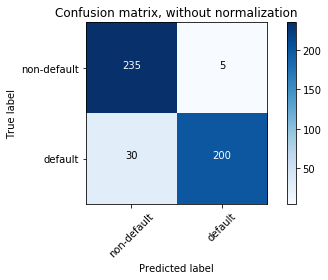

In [140]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

import numpy as np
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non-default','default'],
                      title='Confusion matrix, without normalization')


In [141]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred,digits=4))

              precision    recall  f1-score   support

         0.0     0.8868    0.9792    0.9307       240
         1.0     0.9756    0.8696    0.9195       230

   micro avg     0.9255    0.9255    0.9255       470
   macro avg     0.9312    0.9244    0.9251       470
weighted avg     0.9303    0.9255    0.9252       470



In [101]:
var_dict=dict(zip(X_train.columns,clf.feature_importances_))
var_dict_sorted=sorted(var_dict.items(), key=lambda kv: kv[1],reverse=True)

In [102]:
for i,j in var_dict_sorted[0:10]:
    print('variable is {} and feature importance is {}'.format(i,j))

variable is Agg_col and feature importance is 0.5873423566863996
variable is Original Loan Size and feature importance is 0.06373125897364965
variable is Monthly Instalment and feature importance is 0.06242242699650591
variable is Loan Rate and feature importance is 0.061394056864963964
variable is LTV and feature importance is 0.060769619070819084
variable is APR and feature importance is 0.060340946370207
variable is Original Term and feature importance is 0.041489960833028576
variable is Type 2_A and feature importance is 0.007995199075414613
variable is Type 2_C and feature importance is 0.006550307652685506
variable is Risk Tier_Tier 5 and feature importance is 0.005935083134713984


## classification with logistic regression

In [127]:
num_col=['Original Loan Size', 'Original Term', 'APR', 'LTV',  'Agg_col']
cat_col=[ 'Type 1_A', 'Type 1_B', 'Type 1_C', 'Type 2_A', 'Type 2_B', 'Type 2_C', 'Borrower employement status_Employed', 'Borrower employement status_Other', 'Borrower employement status_Self-employed', 'Risk Tier_Tier 1', 'Risk Tier_Tier 2', 'Risk Tier_Tier 3', 'Risk Tier_Tier 4', 'Risk Tier_Tier 5', 'Risk Tier_Tier 6', 'Risk Tier_Tier 7', 'Risk Tier_Tier 8', 'Risk Tier_Untiered']

In [128]:
from sklearn import preprocessing
scaled_data=preprocessing.scale(train_data[num_col])

scale_train_data=pd.DataFrame(np.append(pd.DataFrame(scaled_data,columns=num_col),train_data[cat_col],axis=1))

In [129]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scale_train_data, train_data['Status 12'], test_size=0.2, stratify= train_data['Status 12'],random_state=42)

In [130]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',
                          ).fit(X_train, y_train)
y_pred=clf.predict(X_test)

/root/anaconda3/envs/shopin/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Confusion matrix
[[6465   67]
 [  26  203]]


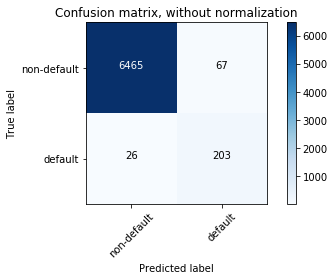

In [131]:
import numpy as np
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['non-default','default'],
                      title='Confusion matrix, without normalization')

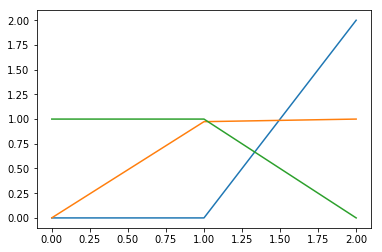

In [56]:
%matplotlib inline
from sklearn.metrics import roc_curve
plt.plot(roc_curve(y_test,y_pred))

In [142]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(train_data['Status 12'])
y_label=le.transform(train_data['Status 12'])
y_label

from sklearn.preprocessing import OneHotEncoder
import numpy as np
y_encoded=np.array(y_label).reshape(len(train_data),1)
one_enc=OneHotEncoder(sparse=False)
y_encoded=one_enc.fit_transform(y_encoded)
y_encoded

/root/anaconda3/envs/shopin/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [143]:
import sklearn

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data[train_num_col], y_encoded, test_size=0.2, stratify= y_encoded,random_state=42)

In [144]:
from sklearn.feature_extraction.text import CountVectorizer
import keras
from keras.layers import merge, Input,InputLayer
from keras.engine import InputLayer
from keras.layers import Dense, Activation, Flatten,Dropout,MaxPool2D,MaxPool1D
from keras.layers.core import Activation, Dense, Flatten
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Dense(32,input_dim=25,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                832       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [146]:
model.fit(x=X_train, y=y_train, epochs=10, batch_size=64,validation_split=0.05)

Train on 1783 samples, validate on 94 samples
Epoch 1/10
1783/1783 [==============================] - 0s 97us/step - loss: 7.8828 - acc: 0.5109 - val_loss: 7.7161 - val_acc: 0.5213
Epoch 2/10
1783/1783 [==============================] - 0s 108us/step - loss: 7.8828 - acc: 0.5109 - val_loss: 7.7161 - val_acc: 0.5213
Epoch 3/10
1783/1783 [==============================] - 0s 101us/step - loss: 7.8828 - acc: 0.5109 - val_loss: 7.7161 - val_acc: 0.5213
Epoch 4/10
1783/1783 [==============================] - 0s 101us/step - loss: 7.8828 - acc: 0.5109 - val_loss: 7.7161 - val_acc: 0.5213
Epoch 5/10
1783/1783 [==============================] - 0s 101us/step - loss: 7.8828 - acc: 0.5109 - val_loss: 7.7161 - val_acc: 0.5213
Epoch 6/10
1783/1783 [==============================] - 0s 99us/step - loss: 7.8828 - acc: 0.5109 - val_loss: 7.7161 - val_acc: 0.5213
Epoch 7/10
1783/1783 [==============================] - 0s 99us/step - loss: 7.8828 - acc: 0.5109 - val_loss: 7.7161 - val_acc: 0.5213
Epoch

In [147]:
y_pred=model.predict(X_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.5106    1.0000    0.6761       240
           1     0.0000    0.0000    0.0000       230

   micro avg     0.5106    0.5106    0.5106       470
   macro avg     0.2553    0.5000    0.3380       470
weighted avg     0.2608    0.5106    0.3452       470
 samples avg     0.5106    0.5106    0.5106       470



/root/anaconda3/envs/shopin/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### It is quite clear that MLP is performing quite poor while predicting default class(number of data points are quite low).